In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 10.3 MB/s eta 0:00:00


Mounted at /content/drive
Found 1888 images belonging to 4 classes.
Found 472 images belonging to 4 classes.


[I 2025-06-21 16:21:48,562] A new study created in memory with name: no-name-70e6ea16-6f53-4d6c-94a3-cedf40ec1676


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-06-21 16:39:29,135] Trial 0 finished with value: 0.9067796468734741 and parameters: {'learning_rate': 4.172872347147016e-05, 'dropout_rate': 0.5180004748228034}. Best is trial 0 with value: 0.9067796468734741.
[I 2025-06-21 16:43:57,286] Trial 1 finished with value: 0.8877118825912476 and parameters: {'learning_rate': 0.0004035328975537817, 'dropout_rate': 0.2166647096577383}. Best is trial 0 with value: 0.9067796468734741.
[I 2025-06-21 16:48:24,129] Trial 2 finished with value: 0.8728813529014587 and parameters: {'learning_rate': 0.00010788380243393997, 'dropout_rate': 0.23278151526585134}. Best is trial 0 with

Best Hyperparameters: {'learning_rate': 4.172872347147016e-05, 'dropout_rate': 0.5180004748228034}
Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.3945 - loss: 1.5153 - val_accuracy: 0.7733 - val_loss: 0.8179 - learning_rate: 4.1729e-05
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 653ms/step - accuracy: 0.6352 - loss: 0.9560 - val_accuracy: 0.8814 - val_loss: 0.5482 - learning_rate: 4.1729e-05
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 652ms/step - accuracy: 0.7482 - loss: 0.7175 - val_accuracy: 0.9025 - val_loss: 0.4516 - learning_rate: 4.1729e-05
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 655ms/step - accuracy: 0.7850 - loss: 0.5864 - val_accuracy: 0.9110 - val_loss: 0.3656 - learning_rate: 4.1729e-05
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 653ms/step - accuracy: 0.8081 - loss: 0.5254 - val_accuracy: 0.9004 - val_loss: 0.3683 - learning_rate: 4.1729e-05
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 652ms/step - accuracy: 0.8139 - loss: 0.4847 - val_accuracy: 0.8983 - val_lo

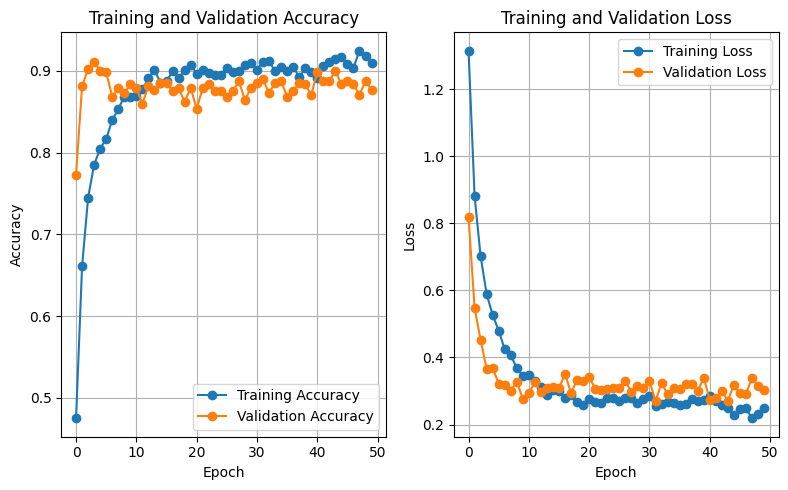

15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


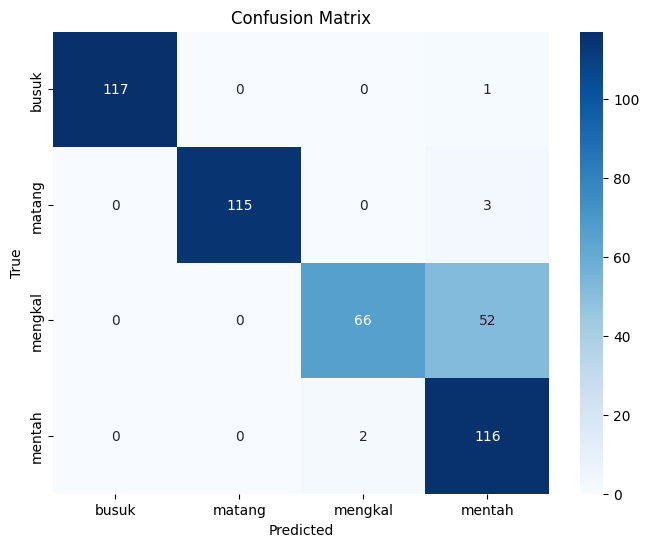

Classification Report:
              precision    recall  f1-score   support

       busuk       1.00      0.99      1.00       118
      matang       1.00      0.97      0.99       118
     mengkal       0.97      0.56      0.71       118
      mentah       0.67      0.98      0.80       118

    accuracy                           0.88       472
   macro avg       0.91      0.88      0.87       472
weighted avg       0.91      0.88      0.87       472



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import optuna
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time

# Mount Google Drive
drive.mount('/content/drive')

# Path dataset
dataset_path = '/content/drive/MyDrive/Sawit'

# Generator untuk data training dan validasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# OPTUNA: Objective Function
def objective(trial):
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    dropout = trial.suggest_float("dropout_rate", 0.2, 0.6)

    base_model = tf.keras.applications.DenseNet201(
        include_top=False, weights='imagenet', input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator, epochs=5, validation_data=val_generator, verbose=0)
    return max(history.history['val_accuracy'])

# Jalankan Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Ambil parameter terbaik
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Build final model with best parameters
base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(best_params['dropout_rate']),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile dan training awal
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=40, callbacks=[reduce_lr])
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[reduce_lr])

# Gabungkan history
for key in fine_tune_history.history:
    history.history[key] += fine_tune_history.history[key]

# Evaluasi akhir
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

# Visualisasi grafik training dan validation accuracy & loss
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluasi akhir (confusion matrix & classification report)
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))


In [ ]:
import tensorflow as tf

# Load model Keras dari file .h5
model = tf.keras.models.load_model("/content/ModelSawit.h5")

# Konversi ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Konversi berhasil: model_sawit.tflite dibuat.")